In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
import tensorflow as tf

he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

/Users/ugis/anaconda3/envs/mlbook/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/ugis/anaconda3/envs/mlbook/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

In [5]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [11]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [12]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [18]:
n_epochs = 1000
batch_size = 25

max_checks_without_progress = 5
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.138786	Best loss: 0.138786	Accuracy: 95.66%
1	Validation loss: 0.073387	Best loss: 0.073387	Accuracy: 98.20%
2	Validation loss: 1.610470	Best loss: 0.073387	Accuracy: 24.04%
3	Validation loss: 1.515214	Best loss: 0.073387	Accuracy: 27.21%
4	Validation loss: 1.632640	Best loss: 0.073387	Accuracy: 22.01%
5	Validation loss: 1.723132	Best loss: 0.073387	Accuracy: 22.01%
6	Validation loss: 1.759777	Best loss: 0.073387	Accuracy: 22.01%
Early stopping!
INFO:tensorflow:Restoring parameters from ./my_mnist_model_0_to_4.ckpt
Final test accuracy: 98.21%


In [22]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 5
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

In [23]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.116407	Best loss: 0.116407	Accuracy: 97.58%
1	Validation loss: 0.180534	Best loss: 0.116407	Accuracy: 97.11%
2	Validation loss: 0.227535	Best loss: 0.116407	Accuracy: 93.86%
3	Validation loss: 0.107346	Best loss: 0.107346	Accuracy: 97.54%
4	Validation loss: 0.302668	Best loss: 0.107346	Accuracy: 95.35%
5	Validation loss: 1.631054	Best loss: 0.107346	Accuracy: 22.01%
6	Validation loss: 1.635262	Best loss: 0.107346	Accuracy: 18.73%
7	Validation loss: 1.671200	Best loss: 0.107346	Accuracy: 22.01%
8	Validation loss: 1.695277	Best loss: 0.107346	Accuracy: 19.27%
9	Validation loss: 1.744607	Best loss: 0.107346	Accuracy: 20.91%
Early stopping!


DNNClassifier(activation=<function elu at 0x11d853730>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x112ea8fd0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [24]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9725627553998832

In [29]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [120, 140, 160],
    "batch_size": [350,400],
    "learning_rate": [0.01],
    "activation": [tf.nn.elu],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=6,
                                random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] learning_rate=0.01, batch_size=350, activation=<function elu at 0x11d853730>, n_neurons=120 
0	Validation loss: 0.102654	Best loss: 0.102654	Accuracy: 96.83%
1	Validation loss: 0.067470	Best loss: 0.067470	Accuracy: 97.62%
2	Validation loss: 0.075195	Best loss: 0.067470	Accuracy: 97.62%
3	Validation loss: 0.050504	Best loss: 0.050504	Accuracy: 98.32%
4	Validation loss: 0.051863	Best loss: 0.050504	Accuracy: 98.63%
5	Validation loss: 0.066369	Best loss: 0.050504	Accuracy: 98.20%
6	Validation loss: 0.052643	Best loss: 0.050504	Accuracy: 98.51%
7	Validation loss: 0.081000	Best loss: 0.050504	Accuracy: 98.12%
8	Validation loss: 0.053567	Best loss: 0.050504	Accuracy: 98.48%
9	Validation loss: 0.066718	Best loss: 0.050504	Accuracy: 98.28%
Early stopping!
[CV]  learning_rate=0.01, batch_size=350, activation=<function elu at 0x11d853730>, n_neurons=120, total=   3.0s
[CV] learning_rate=0.01, batch_size=350, activation=<function e

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


0	Validation loss: 0.103043	Best loss: 0.103043	Accuracy: 96.40%
1	Validation loss: 0.077100	Best loss: 0.077100	Accuracy: 97.58%
2	Validation loss: 0.059739	Best loss: 0.059739	Accuracy: 98.01%
3	Validation loss: 0.060587	Best loss: 0.059739	Accuracy: 98.16%
4	Validation loss: 0.060387	Best loss: 0.059739	Accuracy: 98.16%
5	Validation loss: 0.062347	Best loss: 0.059739	Accuracy: 97.93%
6	Validation loss: 0.051471	Best loss: 0.051471	Accuracy: 98.51%
7	Validation loss: 0.064002	Best loss: 0.051471	Accuracy: 98.40%
8	Validation loss: 0.054955	Best loss: 0.051471	Accuracy: 98.48%
9	Validation loss: 0.057585	Best loss: 0.051471	Accuracy: 98.59%
10	Validation loss: 0.057599	Best loss: 0.051471	Accuracy: 98.59%
11	Validation loss: 0.111087	Best loss: 0.051471	Accuracy: 97.85%
12	Validation loss: 0.061107	Best loss: 0.051471	Accuracy: 98.75%
Early stopping!
[CV]  learning_rate=0.01, batch_size=350, activation=<function elu at 0x11d853730>, n_neurons=120, total=   3.7s
[CV] learning_rate=0.01

0	Validation loss: 0.120318	Best loss: 0.120318	Accuracy: 96.01%
1	Validation loss: 0.087372	Best loss: 0.087372	Accuracy: 97.34%
2	Validation loss: 0.085191	Best loss: 0.085191	Accuracy: 97.38%
3	Validation loss: 0.064810	Best loss: 0.064810	Accuracy: 98.05%
4	Validation loss: 0.066227	Best loss: 0.064810	Accuracy: 98.16%
5	Validation loss: 0.048637	Best loss: 0.048637	Accuracy: 98.48%
6	Validation loss: 0.059078	Best loss: 0.048637	Accuracy: 98.44%
7	Validation loss: 0.053625	Best loss: 0.048637	Accuracy: 98.40%
8	Validation loss: 0.042102	Best loss: 0.042102	Accuracy: 98.87%
9	Validation loss: 0.047383	Best loss: 0.042102	Accuracy: 98.83%
10	Validation loss: 0.064882	Best loss: 0.042102	Accuracy: 98.55%
11	Validation loss: 0.063714	Best loss: 0.042102	Accuracy: 98.24%
12	Validation loss: 0.058097	Best loss: 0.042102	Accuracy: 98.59%
13	Validation loss: 0.052129	Best loss: 0.042102	Accuracy: 98.75%
14	Validation loss: 0.056399	Best loss: 0.042102	Accuracy: 98.67%
Early stopping!
[CV]

5	Validation loss: 0.059148	Best loss: 0.057759	Accuracy: 98.51%
6	Validation loss: 0.067371	Best loss: 0.057759	Accuracy: 98.05%
7	Validation loss: 0.065055	Best loss: 0.057759	Accuracy: 98.51%
8	Validation loss: 0.052672	Best loss: 0.052672	Accuracy: 98.51%
9	Validation loss: 0.047913	Best loss: 0.047913	Accuracy: 98.75%
10	Validation loss: 0.057789	Best loss: 0.047913	Accuracy: 98.67%
11	Validation loss: 0.057472	Best loss: 0.047913	Accuracy: 98.87%
12	Validation loss: 0.059290	Best loss: 0.047913	Accuracy: 98.87%
13	Validation loss: 0.061347	Best loss: 0.047913	Accuracy: 98.75%
14	Validation loss: 0.051408	Best loss: 0.047913	Accuracy: 98.91%
15	Validation loss: 0.054068	Best loss: 0.047913	Accuracy: 98.94%
Early stopping!
[CV]  learning_rate=0.01, batch_size=400, activation=<function elu at 0x11d853730>, n_neurons=140, total=   5.4s
[CV] learning_rate=0.01, batch_size=400, activation=<function elu at 0x11d853730>, n_neurons=160 
0	Validation loss: 0.154108	Best loss: 0.154108	Accu

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.7min finished


0	Validation loss: 0.076566	Best loss: 0.076566	Accuracy: 97.54%
1	Validation loss: 0.062139	Best loss: 0.062139	Accuracy: 98.01%
2	Validation loss: 0.049276	Best loss: 0.049276	Accuracy: 98.55%
3	Validation loss: 0.056261	Best loss: 0.049276	Accuracy: 98.32%
4	Validation loss: 0.033311	Best loss: 0.033311	Accuracy: 98.87%
5	Validation loss: 0.057880	Best loss: 0.033311	Accuracy: 98.48%
6	Validation loss: 0.035102	Best loss: 0.033311	Accuracy: 98.94%
7	Validation loss: 0.053952	Best loss: 0.033311	Accuracy: 98.63%
8	Validation loss: 0.043962	Best loss: 0.033311	Accuracy: 98.71%
9	Validation loss: 0.040287	Best loss: 0.033311	Accuracy: 98.94%
10	Validation loss: 0.045619	Best loss: 0.033311	Accuracy: 98.71%
Early stopping!


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x11d853730>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x112ea8fd0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=6, n_jobs=1,
          param_distributions={'learning_rate': [0.01], 'batch_size': [350, 400], 'activation': [<function elu at 0x11d853730>], 'n_neurons': [120, 140, 160]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [30]:
rnd_search.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.elu>,
 'batch_size': 400,
 'learning_rate': 0.01,
 'n_neurons': 140}

In [31]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9902704806382565

In [32]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

In [35]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=400, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.072285	Best loss: 0.072285	Accuracy: 97.73%
1	Validation loss: 0.055336	Best loss: 0.055336	Accuracy: 98.20%
2	Validation loss: 0.054911	Best loss: 0.054911	Accuracy: 98.55%
3	Validation loss: 0.072201	Best loss: 0.054911	Accuracy: 97.65%
4	Validation loss: 0.056247	Best loss: 0.054911	Accuracy: 98.32%
5	Validation loss: 0.045115	Best loss: 0.045115	Accuracy: 98.71%
6	Validation loss: 0.035851	Best loss: 0.035851	Accuracy: 99.10%
7	Validation loss: 22.659664	Best loss: 0.035851	Accuracy: 55.43%
8	Validation loss: 0.403495	Best loss: 0.035851	Accuracy: 96.99%
9	Validation loss: 0.126746	Best loss: 0.035851	Accuracy: 97.38%
10	Validation loss: 0.110300	Best loss: 0.035851	Accuracy: 97.54%
11	Validation loss: 0.089333	Best loss: 0.035851	Accuracy: 97.93%
12	Validation loss: 0.097720	Best loss: 0.035851	Accuracy: 97.58%
Early stopping!


DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x182b2269d8>,
       batch_norm_momentum=None, batch_size=400, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x112ea8fd0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [36]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9910488421871959

In [37]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.046685	Best loss: 0.046685	Accuracy: 98.63%
1	Validation loss: 0.040820	Best loss: 0.040820	Accuracy: 98.79%
2	Validation loss: 0.046557	Best loss: 0.040820	Accuracy: 98.67%
3	Validation loss: 0.032236	Best loss: 0.032236	Accuracy: 98.94%
4	Validation loss: 0.056148	Best loss: 0.032236	Accuracy: 98.44%
5	Validation loss: 0.035988	Best loss: 0.032236	Accuracy: 98.98%
6	Validation loss: 0.037958	Best loss: 0.032236	Accuracy: 98.94%
7	Validation loss: 0.034588	Best loss: 0.032236	Accuracy: 99.02%
8	Validation loss: 0.031261	Best loss: 0.031261	Accuracy: 99.34%
9	Validation loss: 0.050791	Best loss: 0.031261	Accuracy: 98.79%
10	Validation loss: 0.035324	Best loss: 0.031261	Accuracy: 99.02%
11	Validation loss: 0.039875	Best loss: 0.031261	Accuracy: 98.98%
12	Validation loss: 0.048575	Best loss: 0.031261	Accuracy: 98.94%
13	Validation loss: 0.028059	Best loss: 0.028059	Accuracy: 99.18%
14	Validation loss: 0.044112	Best loss: 0.028059	Accuracy: 99.14%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x182b3a5b70>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x112ea8fd0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [38]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9926055652850749

In [43]:

from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [65, 70, 75],
    "batch_size": [45, 50, 55],
    "learning_rate": [0.01],
    "activation": [tf.nn.relu],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.99],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=9,
                                   fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1)

/Users/ugis/anaconda3/envs/mlbook/lib/python3.5/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] learning_rate=0.01, batch_size=45, activation=<function relu at 0x11d863a60>, batch_norm_momentum=0.99, n_neurons=65 
0	Validation loss: 0.102916	Best loss: 0.102916	Accuracy: 97.22%
1	Validation loss: 0.068699	Best loss: 0.068699	Accuracy: 98.36%
2	Validation loss: 0.069956	Best loss: 0.068699	Accuracy: 98.24%
3	Validation loss: 0.041149	Best loss: 0.041149	Accuracy: 98.71%
4	Validation loss: 0.041666	Best loss: 0.041149	Accuracy: 98.87%
5	Validation loss: 0.059205	Best loss: 0.041149	Accuracy: 98.36%
6	Validation loss: 0.062153	Best loss: 0.041149	Accuracy: 98.20%
7	Validation loss: 0.051112	Best loss: 0.041149	Accuracy: 98.48%
8	Validation loss: 0.042609	Best loss: 0.041149	Accuracy: 98.91%
9	Validation loss: 0.076803	Best loss: 0.041149	Accuracy: 98.08%
Early stopping!
[CV]  learning_rate=0.01, batch_size=45, activation=<function relu at 0x11d863a60>, batch_norm_momentum=0.99, n_neurons=65, total=  17.8s
[CV] learning

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.9s remaining:    0.0s


0	Validation loss: 0.065157	Best loss: 0.065157	Accuracy: 98.20%
1	Validation loss: 0.066359	Best loss: 0.065157	Accuracy: 98.12%
2	Validation loss: 0.065199	Best loss: 0.065157	Accuracy: 98.01%
3	Validation loss: 0.049340	Best loss: 0.049340	Accuracy: 98.48%
4	Validation loss: 0.059891	Best loss: 0.049340	Accuracy: 97.93%
5	Validation loss: 0.055341	Best loss: 0.049340	Accuracy: 98.59%
6	Validation loss: 0.041715	Best loss: 0.041715	Accuracy: 98.75%
7	Validation loss: 0.051146	Best loss: 0.041715	Accuracy: 98.59%
8	Validation loss: 0.043225	Best loss: 0.041715	Accuracy: 98.87%
9	Validation loss: 0.044080	Best loss: 0.041715	Accuracy: 98.98%
10	Validation loss: 0.063841	Best loss: 0.041715	Accuracy: 98.55%
11	Validation loss: 0.052395	Best loss: 0.041715	Accuracy: 98.63%
12	Validation loss: 0.030233	Best loss: 0.030233	Accuracy: 99.06%
13	Validation loss: 0.040267	Best loss: 0.030233	Accuracy: 98.94%
14	Validation loss: 0.128069	Best loss: 0.030233	Accuracy: 97.03%
15	Validation loss: 

1	Validation loss: 0.055996	Best loss: 0.055996	Accuracy: 98.05%
2	Validation loss: 0.066087	Best loss: 0.055996	Accuracy: 98.08%
3	Validation loss: 0.043304	Best loss: 0.043304	Accuracy: 98.75%
4	Validation loss: 0.079713	Best loss: 0.043304	Accuracy: 98.05%
5	Validation loss: 0.040813	Best loss: 0.040813	Accuracy: 98.79%
6	Validation loss: 0.042691	Best loss: 0.040813	Accuracy: 98.94%
7	Validation loss: 0.048238	Best loss: 0.040813	Accuracy: 98.79%
8	Validation loss: 0.057427	Best loss: 0.040813	Accuracy: 98.55%
9	Validation loss: 0.061739	Best loss: 0.040813	Accuracy: 98.55%
10	Validation loss: 0.058114	Best loss: 0.040813	Accuracy: 98.67%
11	Validation loss: 0.034158	Best loss: 0.034158	Accuracy: 98.91%
12	Validation loss: 0.034655	Best loss: 0.034158	Accuracy: 99.06%
13	Validation loss: 0.028408	Best loss: 0.028408	Accuracy: 99.06%
14	Validation loss: 0.044818	Best loss: 0.028408	Accuracy: 98.75%
15	Validation loss: 0.050839	Best loss: 0.028408	Accuracy: 98.75%
16	Validation loss:

0	Validation loss: 0.069197	Best loss: 0.069197	Accuracy: 98.44%
1	Validation loss: 0.058152	Best loss: 0.058152	Accuracy: 98.48%
2	Validation loss: 0.061270	Best loss: 0.058152	Accuracy: 98.28%
3	Validation loss: 0.036191	Best loss: 0.036191	Accuracy: 98.71%
4	Validation loss: 0.031603	Best loss: 0.031603	Accuracy: 98.98%
5	Validation loss: 0.077961	Best loss: 0.031603	Accuracy: 97.77%
6	Validation loss: 0.052401	Best loss: 0.031603	Accuracy: 98.44%
7	Validation loss: 0.058968	Best loss: 0.031603	Accuracy: 98.55%
8	Validation loss: 0.043009	Best loss: 0.031603	Accuracy: 98.79%
9	Validation loss: 0.039525	Best loss: 0.031603	Accuracy: 98.98%
10	Validation loss: 0.044521	Best loss: 0.031603	Accuracy: 98.79%
Early stopping!
[CV]  learning_rate=0.01, batch_size=50, activation=<function relu at 0x11d863a60>, batch_norm_momentum=0.99, n_neurons=70, total=  16.0s
[CV] learning_rate=0.01, batch_size=50, activation=<function relu at 0x11d863a60>, batch_norm_momentum=0.99, n_neurons=75 
0	Valid

17	Validation loss: 0.044766	Best loss: 0.034386	Accuracy: 99.06%
18	Validation loss: 0.051972	Best loss: 0.034386	Accuracy: 98.98%
Early stopping!
[CV]  learning_rate=0.01, batch_size=55, activation=<function relu at 0x11d863a60>, batch_norm_momentum=0.99, n_neurons=65, total=  29.7s
[CV] learning_rate=0.01, batch_size=55, activation=<function relu at 0x11d863a60>, batch_norm_momentum=0.99, n_neurons=70 
0	Validation loss: 0.075533	Best loss: 0.075533	Accuracy: 98.01%
1	Validation loss: 0.094598	Best loss: 0.075533	Accuracy: 97.69%
2	Validation loss: 0.058285	Best loss: 0.058285	Accuracy: 98.36%
3	Validation loss: 0.056714	Best loss: 0.056714	Accuracy: 98.32%
4	Validation loss: 0.059758	Best loss: 0.056714	Accuracy: 98.24%
5	Validation loss: 0.041241	Best loss: 0.041241	Accuracy: 98.87%
6	Validation loss: 0.041631	Best loss: 0.041241	Accuracy: 98.63%
7	Validation loss: 0.057423	Best loss: 0.041241	Accuracy: 98.71%
8	Validation loss: 0.037379	Best loss: 0.037379	Accuracy: 99.10%
9	Vali

9	Validation loss: 0.049015	Best loss: 0.036685	Accuracy: 99.02%
10	Validation loss: 0.046841	Best loss: 0.036685	Accuracy: 98.79%
11	Validation loss: 0.060210	Best loss: 0.036685	Accuracy: 98.51%
12	Validation loss: 0.043711	Best loss: 0.036685	Accuracy: 98.94%
13	Validation loss: 0.080342	Best loss: 0.036685	Accuracy: 98.16%
14	Validation loss: 0.055947	Best loss: 0.036685	Accuracy: 98.71%
Early stopping!
[CV]  learning_rate=0.01, batch_size=55, activation=<function relu at 0x11d863a60>, batch_norm_momentum=0.99, n_neurons=75, total=  22.8s


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 11.2min finished


0	Validation loss: 0.164266	Best loss: 0.164266	Accuracy: 96.13%
1	Validation loss: 0.042195	Best loss: 0.042195	Accuracy: 98.40%
2	Validation loss: 0.040929	Best loss: 0.040929	Accuracy: 98.83%
3	Validation loss: 0.064607	Best loss: 0.040929	Accuracy: 98.20%
4	Validation loss: 0.032527	Best loss: 0.032527	Accuracy: 98.94%
5	Validation loss: 0.036257	Best loss: 0.032527	Accuracy: 98.91%
6	Validation loss: 0.036971	Best loss: 0.032527	Accuracy: 99.06%
7	Validation loss: 0.028221	Best loss: 0.028221	Accuracy: 99.18%
8	Validation loss: 0.037031	Best loss: 0.028221	Accuracy: 98.91%
9	Validation loss: 0.031844	Best loss: 0.028221	Accuracy: 99.14%
10	Validation loss: 0.051240	Best loss: 0.028221	Accuracy: 98.79%
11	Validation loss: 0.030088	Best loss: 0.028221	Accuracy: 99.26%
12	Validation loss: 0.027904	Best loss: 0.027904	Accuracy: 99.34%
13	Validation loss: 0.060909	Best loss: 0.027904	Accuracy: 98.67%
14	Validation loss: 0.031512	Best loss: 0.027904	Accuracy: 99.14%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x11d853730>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x112ea8fd0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'y_valid': array([0, 4, ..., 1, 2], dtype=int32), 'n_epochs': 1000, 'X_valid': array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.]], dtype=float32)},
          iid=True, n_iter=9, n_jobs=1,
          param_distributions={'learning_rate': [0.01], 'batch_size': [45, 50, 55], 'activation': [<function relu at 0x11d863a60>], 'batch_norm_momentum': [0.99], 'n_neurons': [65, 70, 75]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
     

In [44]:
rnd_search_bn.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.relu>,
 'batch_norm_momentum': 0.99,
 'batch_size': 50,
 'learning_rate': 0.01,
 'n_neurons': 70}

In [45]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9959136018680678

In [46]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9975390541408089

In [47]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=400, learning_rate=0.01, 
                                n_neurons=140, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.113220	Best loss: 0.113220	Accuracy: 97.15%
1	Validation loss: 0.094061	Best loss: 0.094061	Accuracy: 97.54%
2	Validation loss: 0.085397	Best loss: 0.085397	Accuracy: 97.69%
3	Validation loss: 0.089503	Best loss: 0.085397	Accuracy: 97.97%
4	Validation loss: 0.079616	Best loss: 0.079616	Accuracy: 97.81%
5	Validation loss: 0.078729	Best loss: 0.078729	Accuracy: 97.97%
6	Validation loss: 0.078287	Best loss: 0.078287	Accuracy: 98.16%
7	Validation loss: 0.087333	Best loss: 0.078287	Accuracy: 97.93%
8	Validation loss: 0.096147	Best loss: 0.078287	Accuracy: 97.89%
9	Validation loss: 0.100612	Best loss: 0.078287	Accuracy: 97.30%
10	Validation loss: 0.204575	Best loss: 0.078287	Accuracy: 93.75%
11	Validation loss: 0.229475	Best loss: 0.078287	Accuracy: 92.06%
12	Validation loss: 0.201846	Best loss: 0.078287	Accuracy: 94.41%
Early stopping!


DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x183457a2f0>,
       batch_norm_momentum=None, batch_size=400, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x112ea8fd0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [48]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9836544074722708

# Excersise 9 - transfer learning

In [49]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

In [50]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [51]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

In [52]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

In [53]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [55]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

In [56]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 10
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 0.871042	Best loss: 0.871042	Accuracy: 69.33%
1	Validation loss: 0.884577	Best loss: 0.871042	Accuracy: 74.00%
2	Validation loss: 0.788313	Best loss: 0.788313	Accuracy: 74.67%
3	Validation loss: 0.728075	Best loss: 0.728075	Accuracy: 78.67%
4	Validation loss: 0.827748	Best loss: 0.728075	Accuracy: 76.00%
5	Validation loss: 0.688189	Best loss: 0.688189	Accuracy: 80.00%
6	Validation loss: 0.806096	Best loss: 0.688189	Accuracy: 76.67%
7	Validation loss: 0.689834	Best loss: 0.688189	Accuracy: 81.33%
8	Validation loss: 0.683314	Best loss: 0.683314	Accuracy: 79.33%
9	Validation loss: 0.653552	Best loss: 0.653552	Accuracy: 80.67%
10	Validation loss: 0.711168	Best loss: 0.653552	Accuracy: 79.33%
11	Validation loss: 0.664902	Best loss: 0.653552	Accuracy: 79.33%
12	Validation loss: 0.745748	Best loss: 0.653552	Accuracy: 75.33%
13	Validation loss: 0.752611	Best loss: 0.653552	Accuracy: 78.67%
14	Validation l

In [57]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

In [59]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.004905	Best loss: 1.004905	Accuracy: 64.67%
1	Validation loss: 0.814947	Best loss: 0.814947	Accuracy: 70.67%
2	Validation loss: 0.844168	Best loss: 0.814947	Accuracy: 70.67%
3	Validation loss: 0.781551	Best loss: 0.781551	Accuracy: 80.00%
4	Validation loss: 0.665440	Best loss: 0.665440	Accuracy: 78.67%
5	Validation loss: 0.727995	Best loss: 0.665440	Accuracy: 77.33%
6	Validation loss: 0.679482	Best loss: 0.665440	Accuracy: 78.67%
7	Validation loss: 0.680531	Best loss: 0.665440	Accuracy: 79.33%
8	Validation loss: 0.663484	Best loss: 0.663484	Accuracy: 78.67%
9	Validation loss: 0.690641	Best loss: 0.663484	Accuracy: 77.33%
10	Validation loss: 0.678349	Best loss: 0.663484	Accuracy: 78.00%
11	Validation loss: 0.731110	Best loss: 0.663484	Accuracy: 78.00%
12	Validation loss: 0.660904	Best loss: 0.660904	Accuracy: 79.33%
13	Validation loss: 0.722856	Best loss: 0.660904	Accuracy: 78.00%
14	Validation l

In [60]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [61]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

In [62]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 0.819070	Best loss: 0.819070	Accuracy: 75.33%
1	Validation loss: 0.849165	Best loss: 0.819070	Accuracy: 76.67%
2	Validation loss: 0.685382	Best loss: 0.685382	Accuracy: 82.00%
3	Validation loss: 0.703680	Best loss: 0.685382	Accuracy: 81.33%
4	Validation loss: 0.718707	Best loss: 0.685382	Accuracy: 79.33%
5	Validation loss: 0.580858	Best loss: 0.580858	Accuracy: 84.67%
6	Validation loss: 0.696760	Best loss: 0.580858	Accuracy: 80.67%
7	Validation loss: 0.594550	Best loss: 0.580858	Accuracy: 83.33%
8	Validation loss: 0.610173	Best loss: 0.580858	Accuracy: 84.67%
9	Validation loss: 0.551225	Best loss: 0.551225	Accuracy: 84.67%
10	Validation loss: 0.611249	Best loss: 0.551225	Accuracy: 83.33%
11	Validation loss: 0.601020	Best loss: 0.551225	Accuracy: 83.33%
12	Validation loss: 0.604198	Best loss: 0.551225	Accuracy: 82.00%
13	Validation loss: 0.609906	Best loss: 0.551225	Accuracy: 80.67%
14	Validation l

In [63]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [64]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 0.758216	Best loss: 0.758216	Accuracy: 80.00%
1	Validation loss: 0.425050	Best loss: 0.425050	Accuracy: 84.67%
2	Validation loss: 0.548179	Best loss: 0.425050	Accuracy: 86.00%
3	Validation loss: 0.451654	Best loss: 0.425050	Accuracy: 87.33%
4	Validation loss: 0.553614	Best loss: 0.425050	Accuracy: 84.00%
5	Validation loss: 0.636999	Best loss: 0.425050	Accuracy: 86.00%
6	Validation loss: 0.596471	Best loss: 0.425050	Accuracy: 86.67%
7	Validation loss: 0.494826	Best loss: 0.425050	Accuracy: 88.00%
8	Validation loss: 0.777300	Best loss: 0.425050	Accuracy: 87.33%
9	Validation loss: 1.114164	Best loss: 0.425050	Accuracy: 82.00%
10	Validation loss: 0.826468	Best loss: 0.425050	Accuracy: 83.33%
11	Validation loss: 0.690591	Best loss: 0.425050	Accuracy: 83.33%
12	Validation loss: 0.689556	Best loss: 0.425050	Accuracy: 86.67%
13	Validation loss: 0.703148	Best loss: 0.425050	Accuracy: 85.33%
14	Valid

In [65]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [66]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 1.616555	Best loss: 1.616555	Accuracy: 57.33%
1	Validation loss: 0.638685	Best loss: 0.638685	Accuracy: 83.33%
2	Validation loss: 1.005454	Best loss: 0.638685	Accuracy: 90.00%
3	Validation loss: 0.493598	Best loss: 0.493598	Accuracy: 83.33%
4	Validation loss: 0.735308	Best loss: 0.493598	Accuracy: 89.33%
5	Validation loss: 0.863948	Best loss: 0.493598	Accuracy: 88.00%
6	Validation loss: 0.916029	Best loss: 0.493598	Accuracy: 90.00%
7	Validation loss: 0.752270	Best loss: 0.493598	Accuracy: 88.00%
8	Validation loss: 1.768208	Best loss: 0.493598	Accuracy: 87.33%
9	Validation loss: 1.481399	Best loss: 0.493598	Accuracy: 92.67%
10	Validation loss: 1.929936	Best loss: 0.493598	Accuracy: 89.33%
11	Validation loss: 1.645900	Best loss: 0.493598	Accuracy: 90.67%
12	Validation loss: 2.263128	Best loss: 0.493598	Accuracy: 92.00%
13	Validation loss: 2.014274	Best loss: 0.493598	Accuracy: 91.33%
14	Valida

In [67]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.674618	Best loss: 0.674618	Accuracy: 80.67%
1	Validation loss: 0.584845	Best loss: 0.584845	Accuracy: 88.67%
2	Validation loss: 0.647296	Best loss: 0.584845	Accuracy: 84.00%
3	Validation loss: 0.530389	Best loss: 0.530389	Accuracy: 87.33%
4	Validation loss: 0.683215	Best loss: 0.530389	Accuracy: 90.67%
5	Validation loss: 0.538040	Best loss: 0.530389	Accuracy: 89.33%
6	Validation loss: 0.670196	Best loss: 0.530389	Accuracy: 90.67%
7	Validation loss: 0.836470	Best loss: 0.530389	Accuracy: 85.33%
8	Validation loss: 0.837684	Best loss: 0.530389	Accuracy: 92.67%
9	Validation loss: 0.588950	Best loss: 0.530389	Accuracy: 88.00%
Early stopping!


DNNClassifier(activation=<function elu at 0x11d853730>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x112ea8fd0>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [68]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8481793869574161

# 10. Pretraining

In [70]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

In [72]:
y = tf.placeholder(tf.int32, shape=[None, 1])

In [73]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

In [74]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

In [75]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [77]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

In [78]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

In [79]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

In [80]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

In [81]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

In [82]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [84]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

In [85]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [86]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

In [87]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

In [88]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

In [89]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

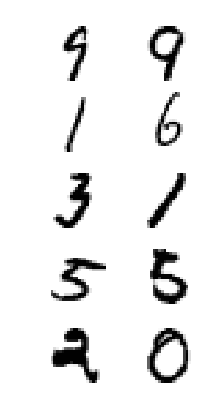

In [90]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [91]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

In [92]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

In [93]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 Train loss: 0.69103277
0 Test accuracy: 0.542
1 Train loss: 0.6035354
2 Train loss: 0.54946035
3 Train loss: 0.47047246
4 Train loss: 0.4060757
5 Train loss: 0.38308156
5 Test accuracy: 0.824
6 Train loss: 0.39047274
7 Train loss: 0.3390794
8 Train loss: 0.3210671
9 Train loss: 0.31792685
10 Train loss: 0.24494292
10 Test accuracy: 0.8881
11 Train loss: 0.2929235
12 Train loss: 0.23225449
13 Train loss: 0.23180929
14 Train loss: 0.19877923
15 Train loss: 0.20065464
15 Test accuracy: 0.9203
16 Train loss: 0.19700499
17 Train loss: 0.18893136
18 Train loss: 0.19965452
19 Train loss: 0.24071647
20 Train loss: 0.18882024
20 Test accuracy: 0.9367
21 Train loss: 0.12419197
22 Train loss: 0.14013417
23 Train loss: 0.120789476
24 Train loss: 0.15721135
25 Train loss: 0.11507861
25 Test accuracy: 0.948
26 Train loss: 0.13891116
27 Train loss: 0.1526081
28 Train loss: 0.123436704
29 Train loss: 0.11543139
30 Train loss: 0.1140282
30 Test accuracy: 0.9507
31 Train loss: 0.11897083
32 Train loss

In [94]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [95]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9455
10 Test accuracy: 0.9634
20 Test accuracy: 0.9659
30 Test accuracy: 0.9656
40 Test accuracy: 0.9655
50 Test accuracy: 0.9656
60 Test accuracy: 0.9655
70 Test accuracy: 0.9656
80 Test accuracy: 0.9654
90 Test accuracy: 0.9654


In [96]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [97]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.8694
10 Test accuracy: 0.9276
20 Test accuracy: 0.9299
30 Test accuracy: 0.935
40 Test accuracy: 0.942
50 Test accuracy: 0.9435
60 Test accuracy: 0.9442
70 Test accuracy: 0.9447
80 Test accuracy: 0.9448
90 Test accuracy: 0.945
100 Test accuracy: 0.945
110 Test accuracy: 0.9458
120 Test accuracy: 0.9456
130 Test accuracy: 0.9458
140 Test accuracy: 0.9458
